In [1]:
%load_ext autoreload
%autoreload 2

import json, os

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.ticker as mtick
import matplotlib as mpl
from matplotlib.patches import FancyArrowPatch

from Experiment import Experiment2D
from figure_functions import compute_rolling_average, prediction_compare_plot, latent_space_plot, loss_boxplot, training_loss_epochs_plot

In [2]:
# Set plotting parameters
global_params = {'figure.dpi': 300,
                 'text.usetex': True,
                 'text.latex.preamble': r"\usepackage{amsmath}",
                 'font.family': 'sans-serif',
                 'savefig.dpi': 300,
                 'savefig.bbox': 'tight',
                 'savefig.pad_inches': 0.025,
                 'savefig.transparent': True,
                 #'font.sans-serif': 'Computer Modern Roman',
                }

full_params = {'figure.figsize': (7.3, 3.65),
               'figure.titlesize': 12,
               'axes.labelsize': 10,
               'axes.titlesize': 12,
               'legend.fontsize': 10,
               'xtick.labelsize': 12,
               'ytick.labelsize': 12,
              }

half_params = {'figure.figsize': (3.5, 2.5),
               'figure.titlesize': 10,
               'lines.linewidth' : 1,
               'lines.markersize' : 6,
               'lines.markeredgewidth': 0.5,
               'axes.labelsize': 9,
               'axes.titlesize': 9,
               'axes.linewidth': 0.5,
               'legend.fontsize': 9,
               'xtick.labelsize': 9,
               'ytick.labelsize': 9,
               'xtick.major.width': 0.5,
               'ytick.major.width': 0.7,
               'ytick.minor.width': 0.5,
               'ytick.major.pad': 0.0,
              }

# Add global parameters to the full_params and half_params dictionaries
full_params.update(global_params)
half_params.update(global_params)

# Set up boxplot-specific options
boxplot_params={'boxplot.boxprops.linewidth': 0.5,
                'boxplot.whiskerprops.linewidth': 0.5,
                'boxplot.capprops.linewidth': 0.5,
                'boxplot.medianprops.linewidth' : 0.5,
               }

# Boolean determining if figures should be saved (all figures or summary-only)
saveallfigs = False
savesumfigs = False

In [33]:
def plot_predict_vs_true(i, pred_u, pred_f, u, f, fig, ax1, ax2):
    
    # Grab the 'true' value
    true_u = u[i,:,:]
    true_F = f[i,:,:]

    # And predicted value
    predict_u = pred_u[i,:,:]
    predict_F = pred_f[i,:,:]

    # create a space vector
    x = np.linspace(0,2*np.pi, predict_u.shape[0])
    X, Y = np.meshgrid(x,x)
    
    # Set colorbar limits
    uMax = np.max(np.vstack((true_u, predict_u)))
    uMin = np.min(np.vstack((true_u, predict_u)))
    FMax = np.max(np.vstack((true_F, predict_F)))
    FMin = np.min(np.vstack((true_F, predict_F)))
    uInf = np.max((abs(uMax), abs(uMin)))
    FInf = np.max((abs(FMax), abs(FMin)))
    
    Diff_u = (true_u-predict_u)/uInf
    DuMax = np.max(Diff_u)
    DuMin = np.min(Diff_u)
    DuInf = np.max((abs(DuMax), abs(DuMin)))
    
    Diff_F = (true_F-predict_F)/FInf
    DFMax = np.max(Diff_F)
    DFMin = np.min(Diff_F)
    DFInf = np.max((abs(DFMax), abs(DFMin)))
    
    uStr = "{:.0e}".format(uInf)
    uLim = float(uStr)
    FStr = "{:.0e}".format(FInf)
    FLim = float(FStr)
    DuStr = "{:.0e}".format(DuInf)
    DuLim = float(DuStr)
    DFStr = "{:.0e}".format(DFInf)
    DFLim = float(DFStr)
    
    # Create the figures
    ax = ax1[0]
    cont = ax.contourf(X, Y, true_u, levels=100, vmin=-uLim, vmax=uLim)
    cbar = fig.colorbar(cont, ax=ax, ticks=[-uLim, 0, uLim])
    cbar.ax.set_yticklabels(['-' + uStr, '0', uStr])  
    #cbar = fig.colorbar(cont, ax=ax, format='%.0e')
    #cbar.ax.locator_params(nbins=3)
    ax.set_title(r'True')
    ax.set_ylabel(r"$\mathbf{u}(x)$")
    ax.set_xlim([0,2*np.pi])
    ax.set_yticks([0, np.pi, 2*np.pi])
    ax.set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
    ax.set_ylim([0,2*np.pi])

    ax = ax2[0]
    cont = ax.contourf(X, Y, true_F, levels=100, vmin=-FLim, vmax=FLim)
    cbar = fig.colorbar(cont, ax=ax, ticks=[-FLim, 0, FLim])
    cbar.ax.set_yticklabels(['-' + FStr, '0', FStr])  
    #cbar = fig.colorbar(cont, ax=ax, format='%.0e')
    #cbar.ax.locator_params(nbins=3)
    ax.set_ylabel(r"$\mathbf{F}(x)$")
    ax.set_xticks([0, np.pi, 2*np.pi])
    ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
    ax.set_xlim([0,2*np.pi])
    ax.set_yticks([0, np.pi, 2*np.pi])
    ax.set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
    ax.set_ylim([0,2*np.pi])
    
    ax = ax1[1]
    cont = ax.contourf(X, Y, predict_u, levels=100, vmin=-uLim, vmax=uLim)
    cbar = fig.colorbar(cont, ax=ax, ticks=[-uLim, 0, uLim])
    cbar.ax.set_yticklabels(['-' + uStr, '0', uStr])  
    #cbar = fig.colorbar(cont, ax=ax, format='%.0e')
    #cbar.ax.locator_params(nbins=3)
    ax.set_title(r'Predicted')
    ax.set_xlim([0,2*np.pi])
    ax.set_ylim([0,2*np.pi])

    ax = ax2[1]
    cont = ax.contourf(X, Y, predict_F, levels=100, vmin=-FLim, vmax=FLim)
    cbar = fig.colorbar(cont, ax=ax, ticks=[-FLim, 0, FLim])
    cbar.ax.set_yticklabels(['-' + FStr, '0', FStr])  
    #cbar = fig.colorbar(cont, ax=ax, format='%.0e')
    #cbar.ax.locator_params(nbins=3)
    ax.set_xticks([0, np.pi, 2*np.pi])
    ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
    ax.set_xlim([0,2*np.pi])
    ax.set_ylim([0,2*np.pi])
    
    ax = ax1[2]
    cont = ax.contourf(X, Y, Diff_u, 100, vmin=-DuLim, vmax=DuLim)
    cbar = fig.colorbar(cont, ax=ax, ticks=[-DuLim, 0, DuLim])
    cbar.ax.set_yticklabels(['-' + DuStr, '0', DuStr])  
    #cbar = fig.colorbar(cont, ax=ax, format='%.0e')
    #cbar.ax.locator_params(nbins=3)
    ax.set_title('Difference')
    ax.set_xlim([0,2*np.pi])
    ax.set_ylim([0,2*np.pi])

    ax = ax2[2]
    cont = ax.contourf(X, Y, Diff_u, 100, vmin=-DFLim, vmax=DFLim)
    cbar = fig.colorbar(cont, ax=ax, ticks=[-DFLim, 0, DFLim])
    cbar.ax.set_yticklabels(['-' + DFStr, '0', DFStr]) 
    #cbar = fig.colorbar(cont, ax=ax, format='%.0e')
    #cbar.ax.locator_params(nbins=3)
    ax.set_xticks([0, np.pi, 2*np.pi])
    ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
    ax.set_xlim([0,2*np.pi])
    ax.set_ylim([0,2*np.pi])
    
    # Change spacing
    fig.subplots_adjust(wspace=0.3, hspace=0.2)#, left=0.05, right=0.07)

In [34]:
def generate_compare_plot(expt, data_name, saveallfigs=False):
    
    modes = ['Best', 'Mean', 'Worst']
    
    u = expt.data['{}_u'.format(data_name)]
    F = expt.data['{}_f'.format(data_name)]
    
    for j in range(3):
        mode = modes[j]   
        
        fig, [ax1, ax2] = plt.subplots(2,3, sharex=True, sharey=True)
        i = expt.find_sample(dataset_name=data_name, mode=mode)
        u_pred, F_pred = expt.predict_uF(u, F)

        plot_predict_vs_true(i, u_pred, F_pred, u, F, fig, ax1, ax2)
        
        if saveallfigs:
            plt.savefig("{}-{}-{}pred.png".format(expt.name, mode, data_name), transparent=True)
    
        plt.show()

In [35]:
# Load up the different experiments for analysis
s3 = Experiment2D(experiment_name="S3-NLP-Expt1-L200-a", data_file_prefix='S3-NLP')

expt = s3

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (3).

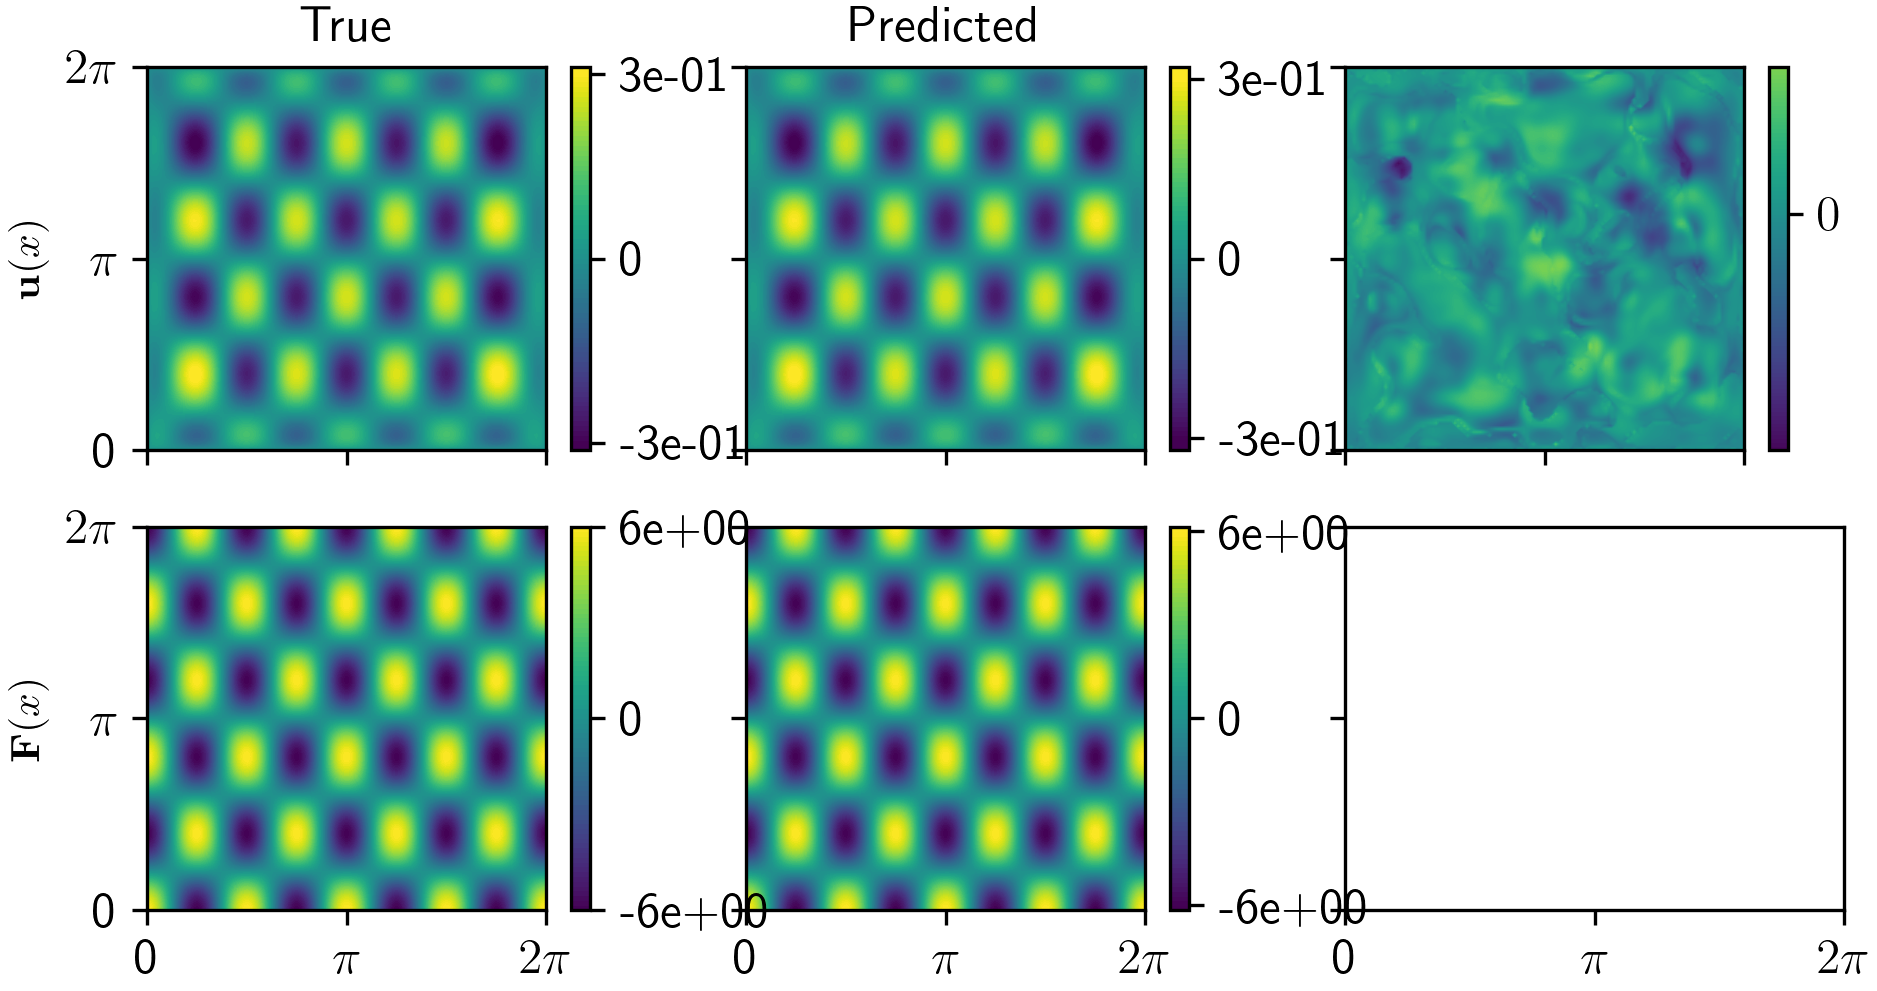

In [36]:
plt.rcdefaults()
plt.rcParams.update(full_params)

generate_compare_plot(expt, 'val', saveallfigs)

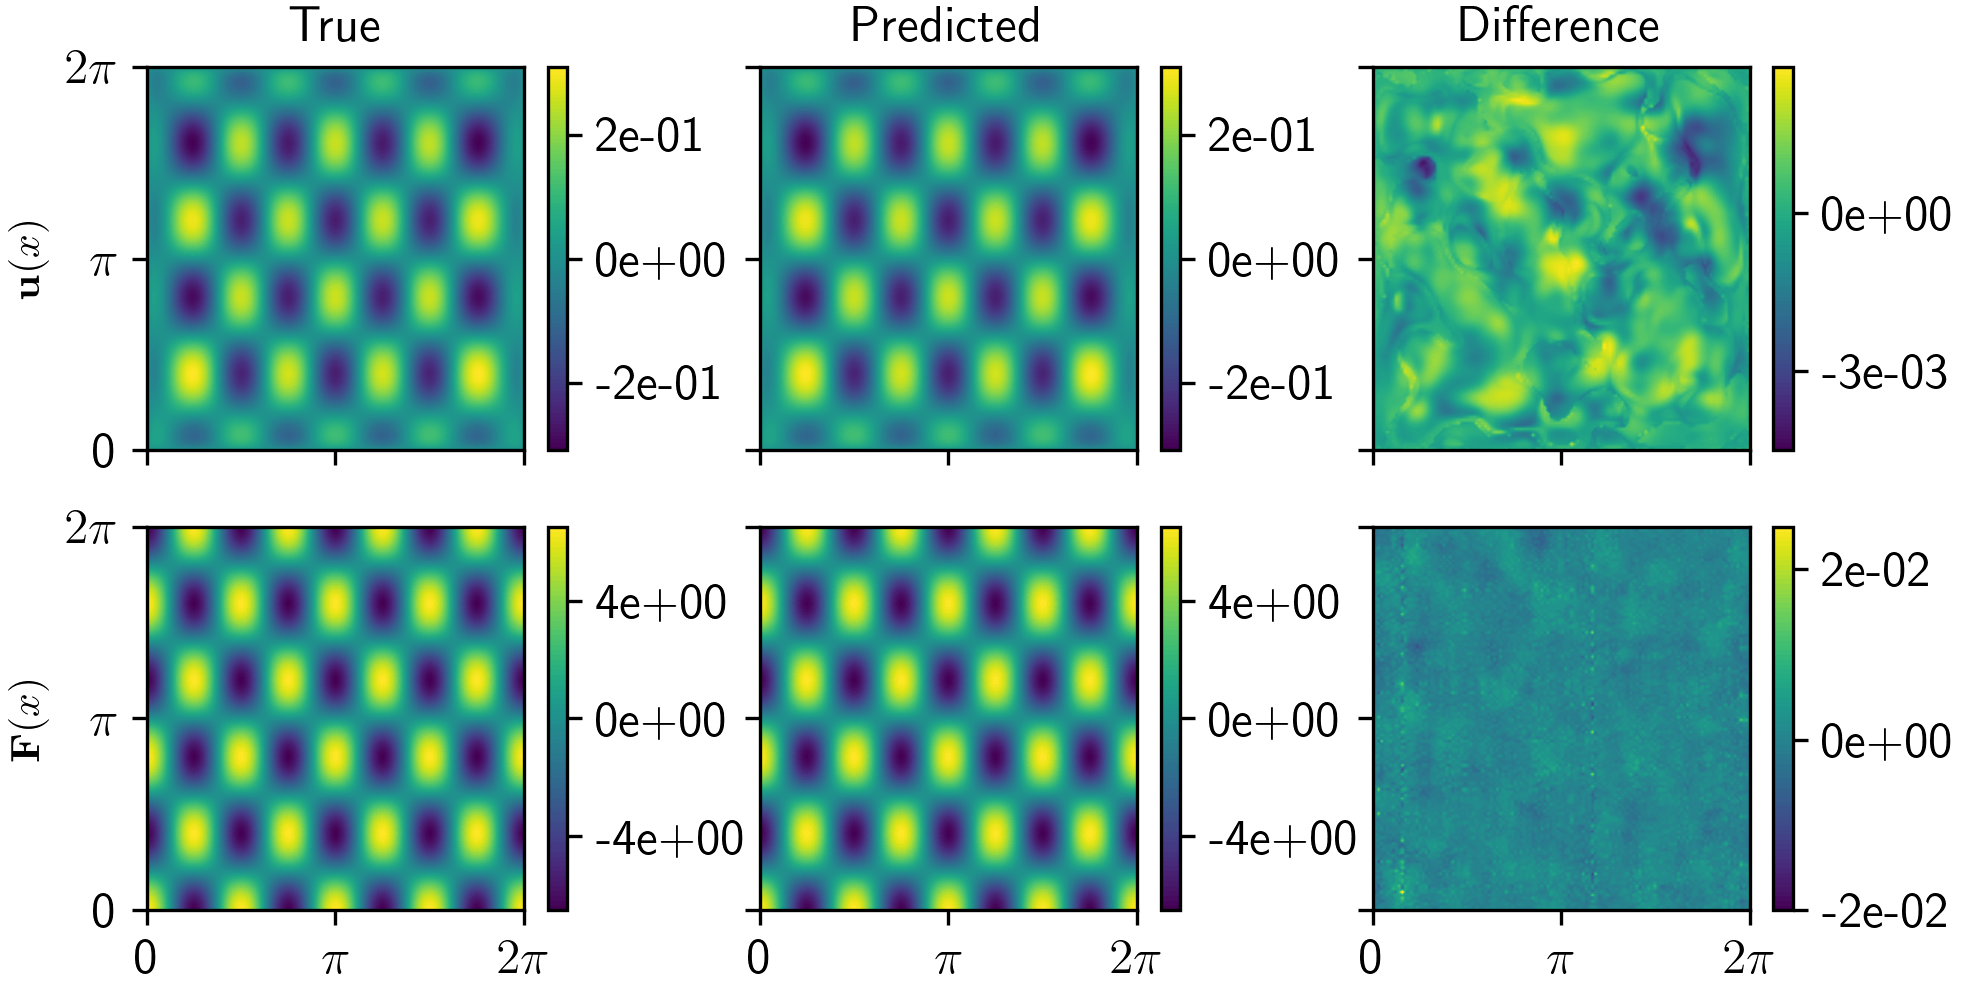

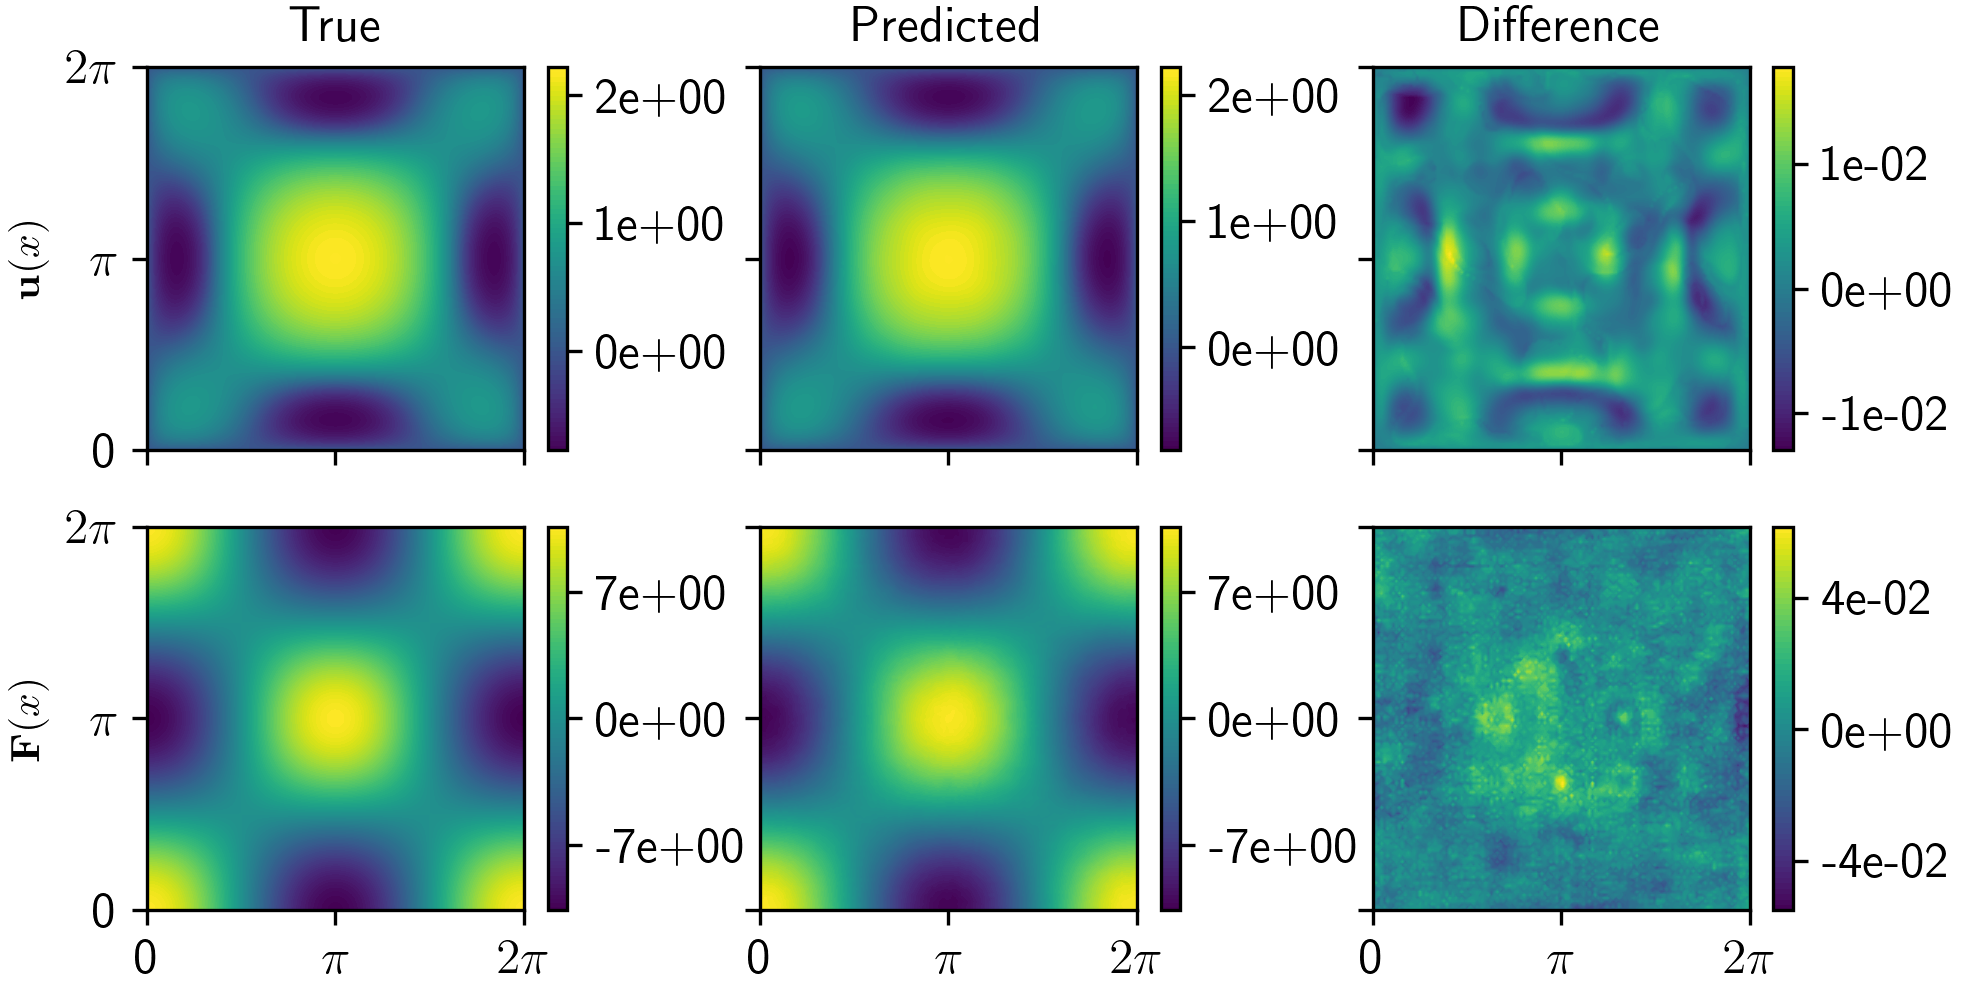

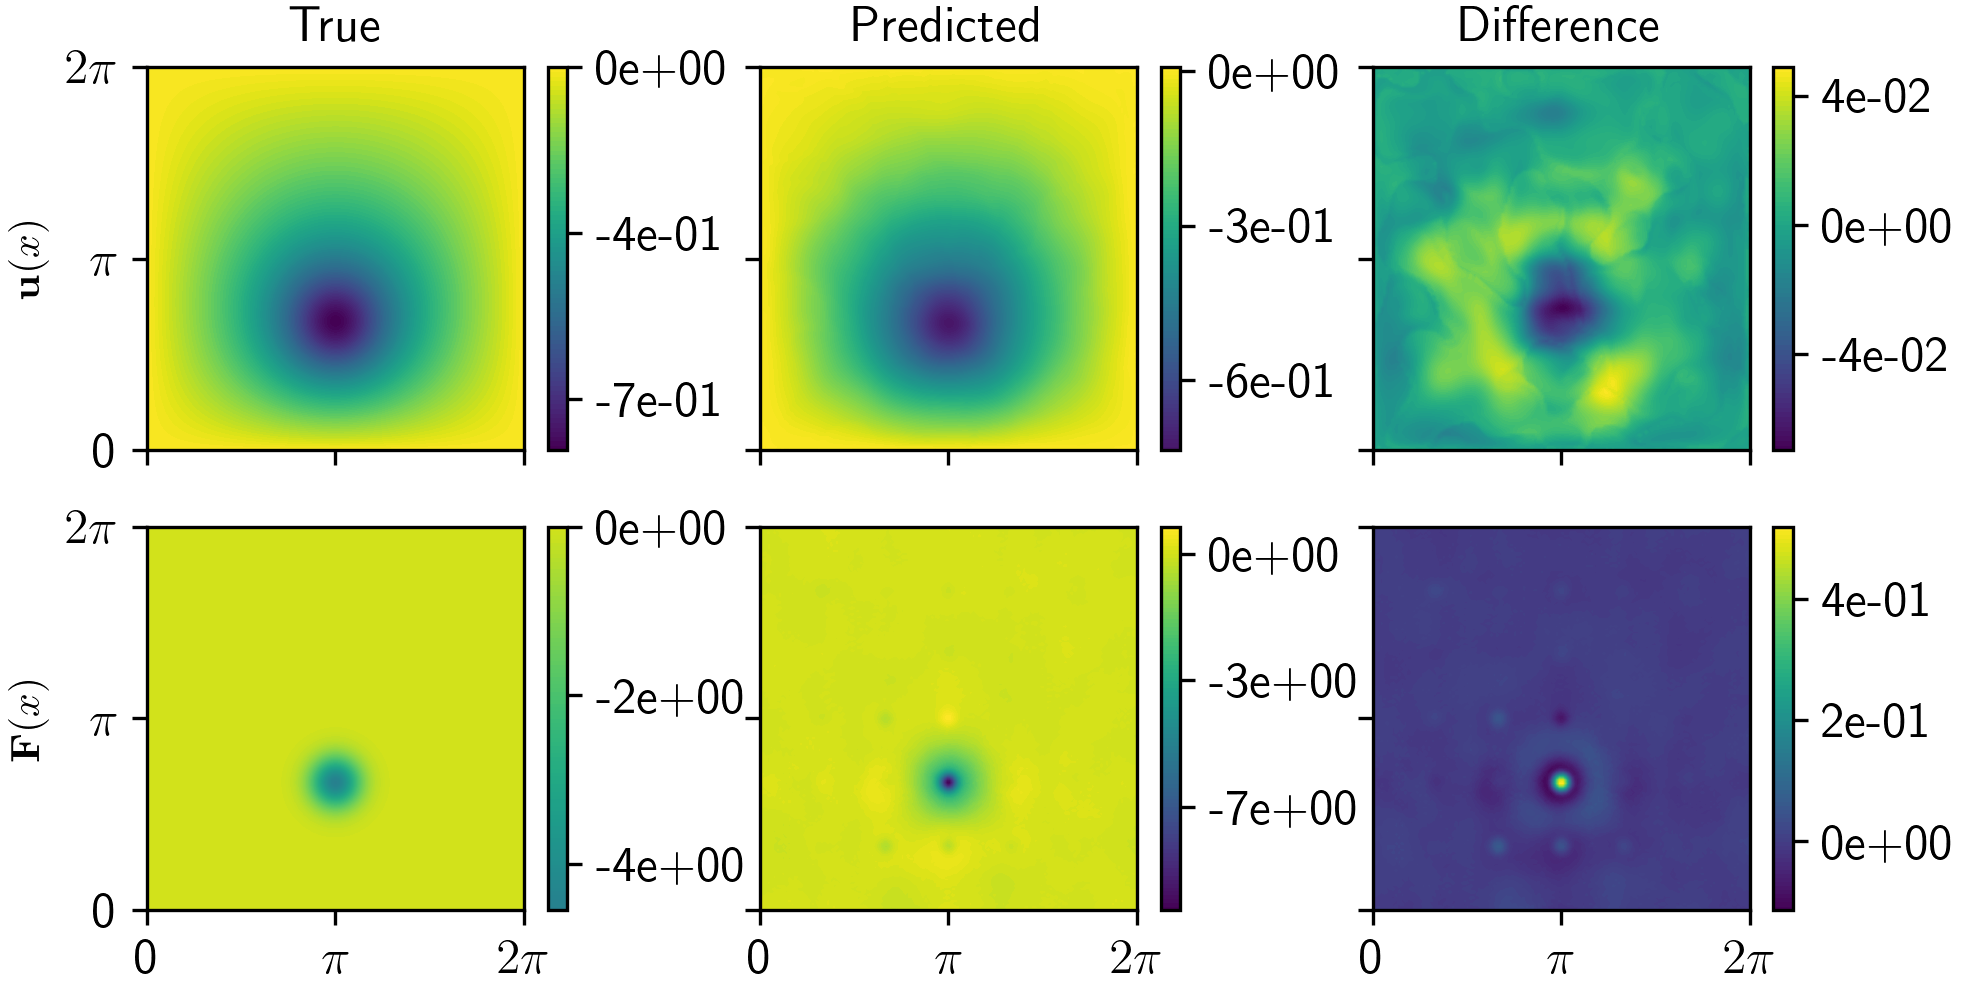

In [7]:
plt.rcdefaults()
plt.rcParams.update(full_params)

generate_compare_plot(expt, 'test1', saveallfigs)

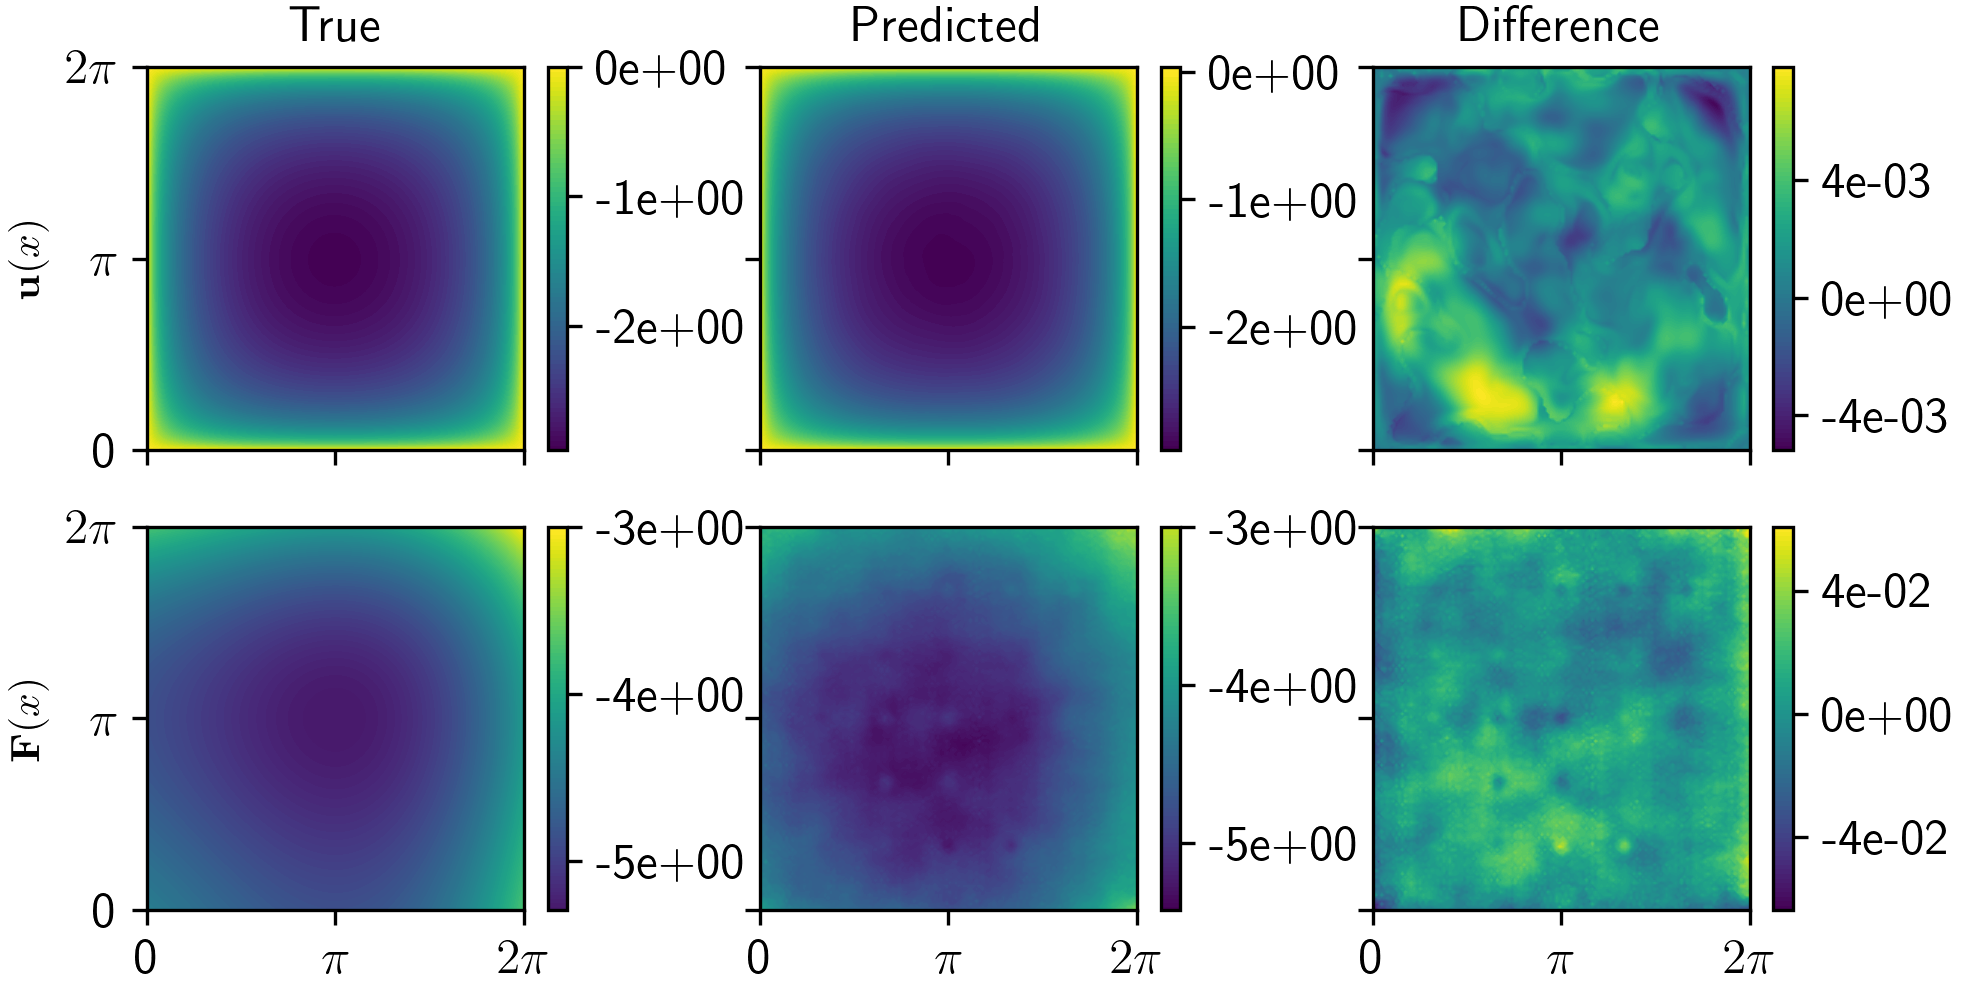

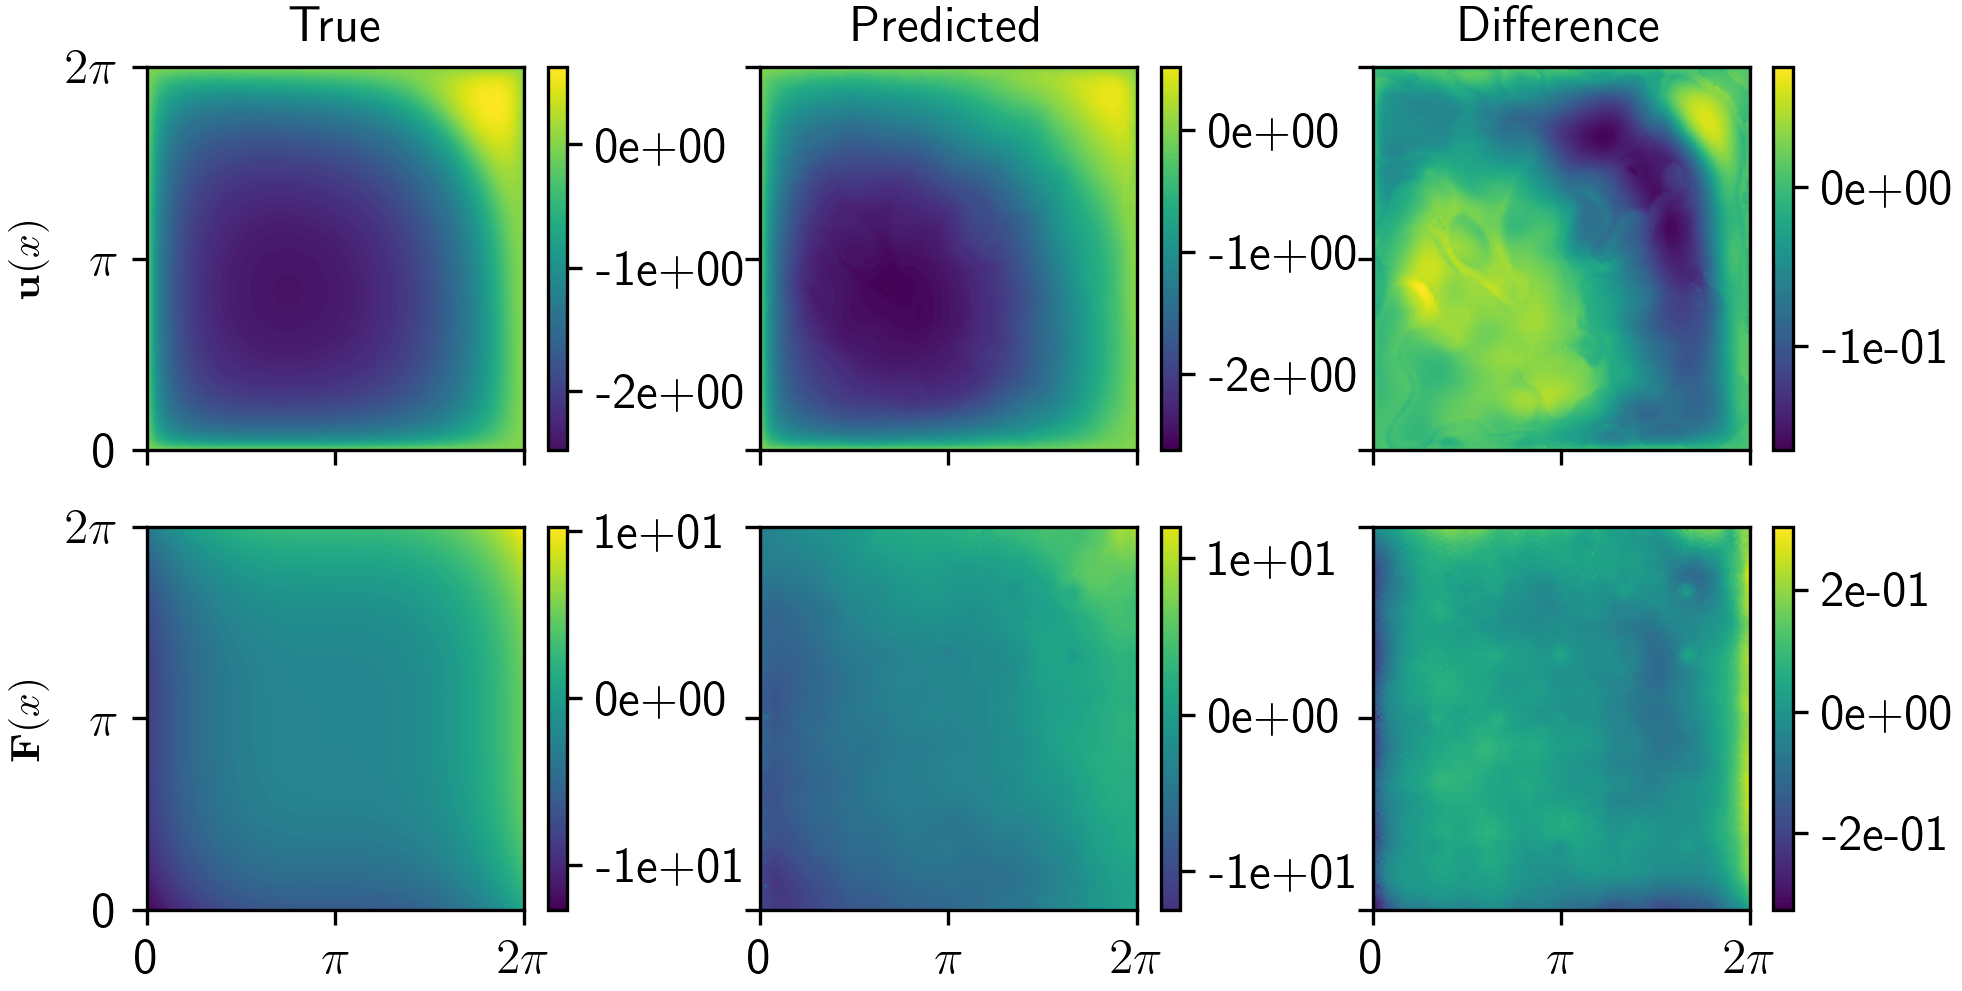

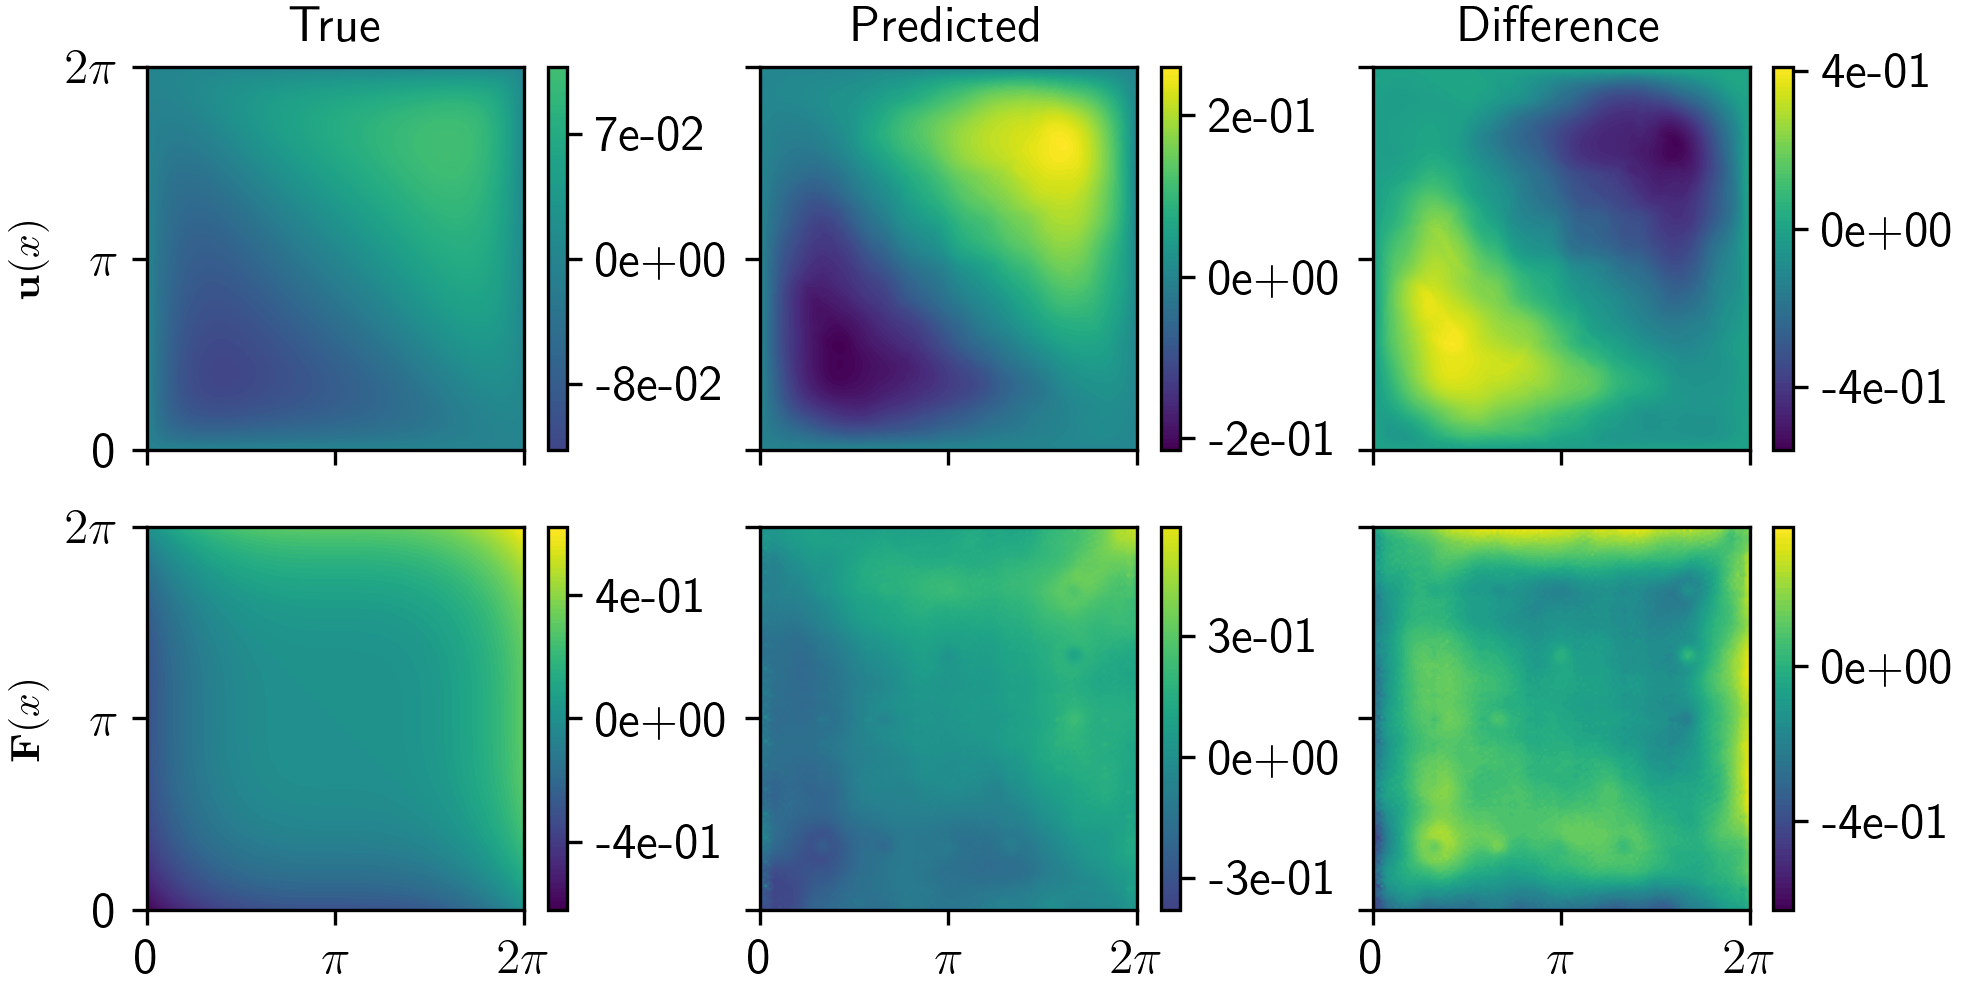

In [8]:
plt.rcdefaults()
plt.rcParams.update(full_params)

generate_compare_plot(expt, 'test2', saveallfigs)

In [9]:
# From https://stackoverflow.com/questions/11209646/waterfall-plot-python

from matplotlib.collections import LineCollection

def waterfall_plot(fig, ax, X, Y, Z, **kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        lc = LineCollection(segments, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    #fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

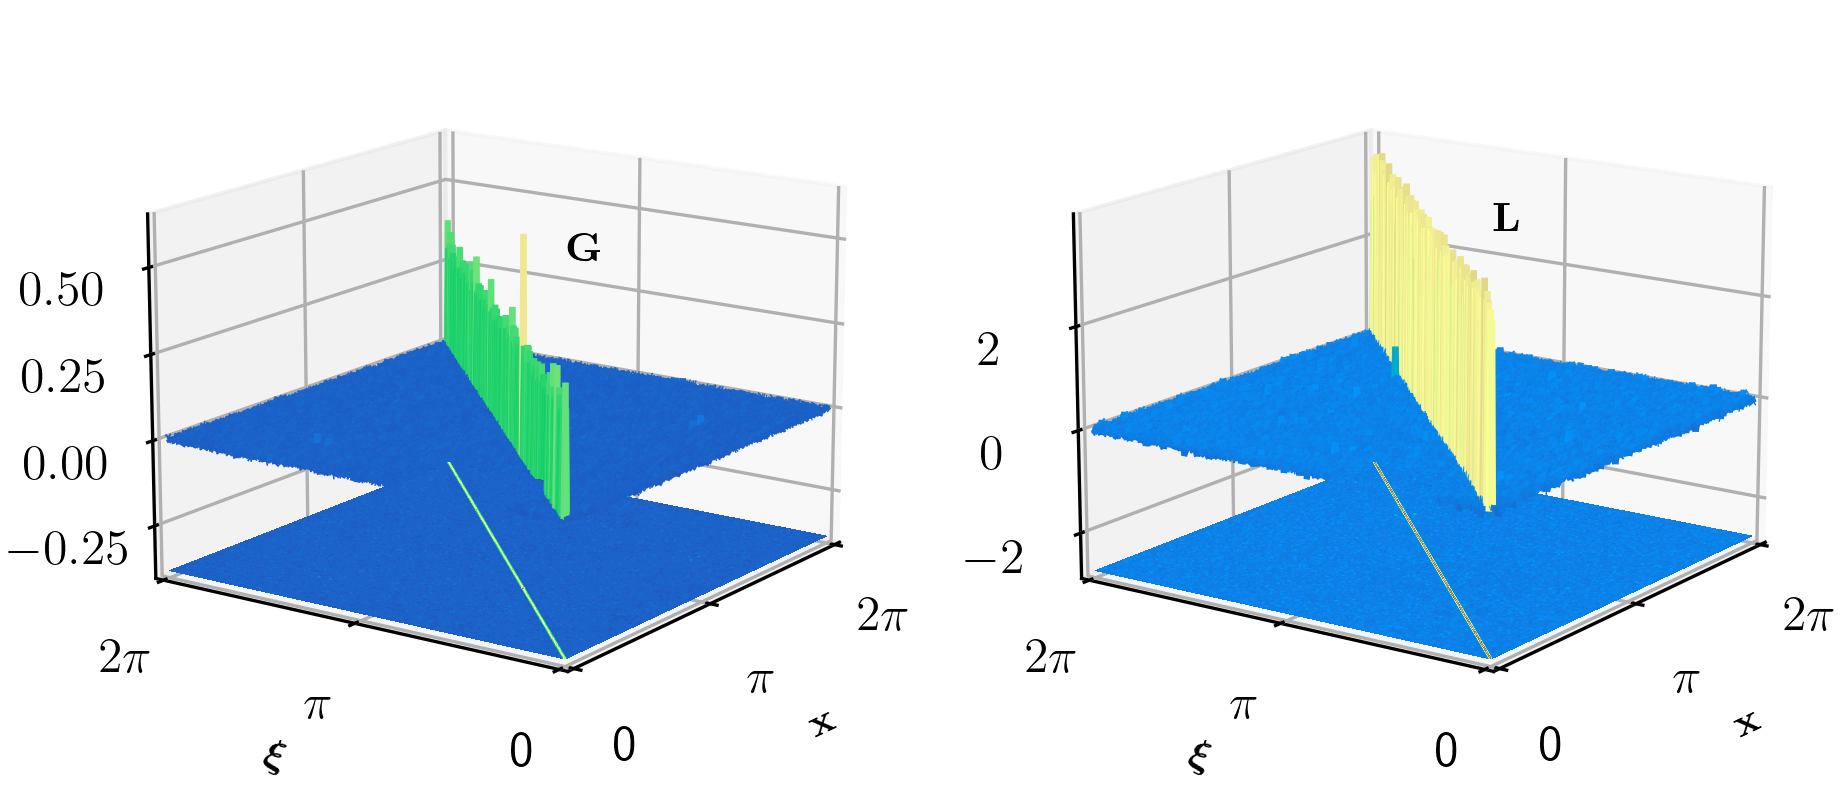

In [10]:
plt.rcdefaults()
plt.rcParams.update(full_params)

# Grab the relevant L and G matrices
L = np.array(expt.L)
G = expt.G

# Set up and plot
x = np.linspace(0,2*np.pi, L.shape[0])
X,XI = np.meshgrid(x,x)

# Options
cmap = 'terrain'
waterfall_opts = dict(linewidth=1.5, alpha=1.0, cmap=cmap)
contour_opts = dict(levels=100, zdir='z', cmap=cmap)

# Set limits for z-axis
Gm = np.min(G)
GM = np.max(G)
Goffset = Gm - 0.5 * (GM - Gm)
Lm = np.min(L)
LM = np.max(L)
Loffset = Lm - 0.5 * (LM - Lm)

fig = plt.figure(figsize=(7.3,3.65))

# set up the axes for the first plot, plot G
ax = fig.add_subplot(1, 2, 1, projection='3d')
waterfall_plot(fig, ax, X, XI, G, **waterfall_opts) 
ax.contourf(X, XI, G, offset=Goffset, vmin=Gm, vmax=GM, **contour_opts)

# Format x-axis
ax.set_xlabel(r"$\mathbf{x}$")
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
ax.set_xlim([0,2*np.pi])

# Format xi-axis
ax.set_ylabel(r'$\boldsymbol{\xi}$')
ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
ax.set_ylim([0,2*np.pi])

# Format z-axis
ax.set_zlim(Goffset, GM)

# Place the z-axis label using text command
ax.text(x=0, y=0, z=0.7, s=r'$\mathbf{G}$')#rotation_mode=None, rotation=180)

# Set up the view position angle
ax.view_init(15,215)

# set up the axes for the second plot, plot L
ax = fig.add_subplot(1, 2, 2, projection='3d')
waterfall_plot(fig, ax, X, XI, L, **waterfall_opts) 
ax.contourf(X, XI, L, offset=Loffset, vmin=Lm, vmax=LM, **contour_opts)

# Format x-axis
ax.set_xlabel(r"$\mathbf{x}$")
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels(["0", r"$\pi$", r"$2\pi$"])
ax.set_xlim([0,2*np.pi])

# Format xi-axis
ax.set_ylabel(r'$\boldsymbol{\xi}$')
ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
ax.set_ylim([0,2*np.pi])

# Format z-axis
ax.set_zlim(Loffset, LM)

# Place the z-axis label using text command
ax.text(x=0, y=0, z=5.0, s=r'$\mathbf{L}$')#rotation_mode=None, rotation=180)

# Set up the view position angle
ax.view_init(15,215)

# Change spacing
#plt.subplots_adjust(wspace=-0.18, hspace=0.0)#, left=0.05, right=0.07)


if saveallfigs:
    plt.savefig("{}-L_and_G.png".format(expt.name), transparent=True)
    
plt.show()

In [11]:
def latent_space_plot(expt, index, dataset_name='train1'):
    # Set up the plotting vectors
    v, f = expt.encode_vf(index=index, dataset_name='train1')
    x = np.linspace(0, 2*np.pi, f.shape[0])

    # Some plotting options
    aec_line = dict(color='orange', lw=2, mfc='orange')
    aec_line2 = dict(color='cornflowerblue', lw=1, mfc='cornflowerblue')
    #aec_line = dict(color='orange', marker='o', mfc='orange', mec='black')
    #aec_line2 = dict(color='cornflowerblue', marker='d', mfc='cornflowerblue', mec='black')

    # And now plot it!
    fig = plt.figure()

    #Plot the v and f vectors
    plt.plot(x, v, **aec_line, label=r'$\boldsymbol{\psi}_u \mathbf{u}(\mathbf{x})$')
    plt.plot(x, f, **aec_line2, label=r'$\boldsymbol{\psi}_F \mathbf{F}(\mathbf{x})$')
    
    #Place the legend and label the axes
    plt.legend(loc='lower left')
    plt.ylabel(r"$\mathbf{f}(\mathbf{x})$, $\mathbf{v}(\mathbf{x})$")
    plt.xlabel(r"$\mathbf{x}$")

    # Format x-axis
    plt.xlabel(r"$\mathbf{x}$")
    plt.xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])
    plt.xlim([0,2*np.pi])


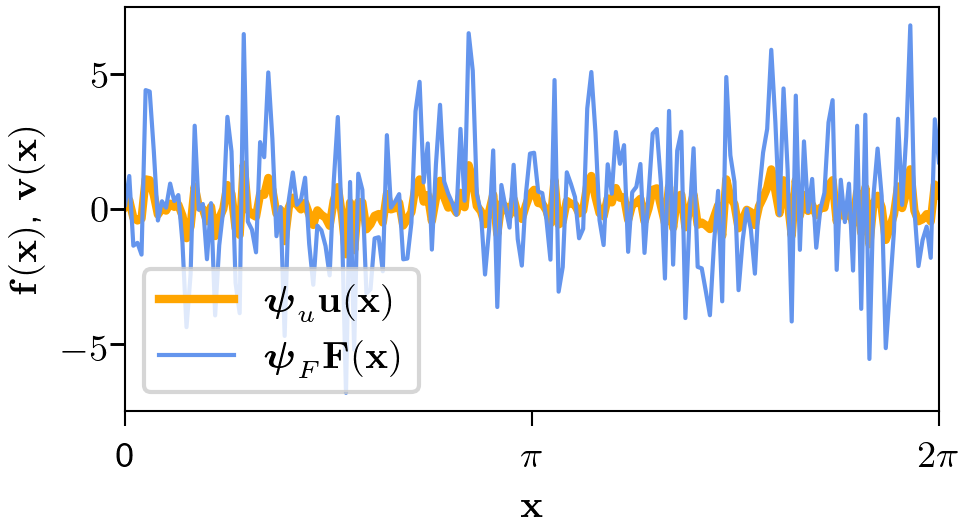

In [12]:
plt.rcdefaults()
plot_params = half_params.copy()
plot_params['figure.figsize'] = (3.5,1.75)
plt.rcParams.update(plot_params)

i = expt.find_sample(dataset_name='train1', mode='Mean')
latent_space_plot(expt, index=i, dataset_name='train1')

if saveallfigs:
    plt.savefig("{}-latentspace.png".format(expt.name), transparent=True)

plt.show()

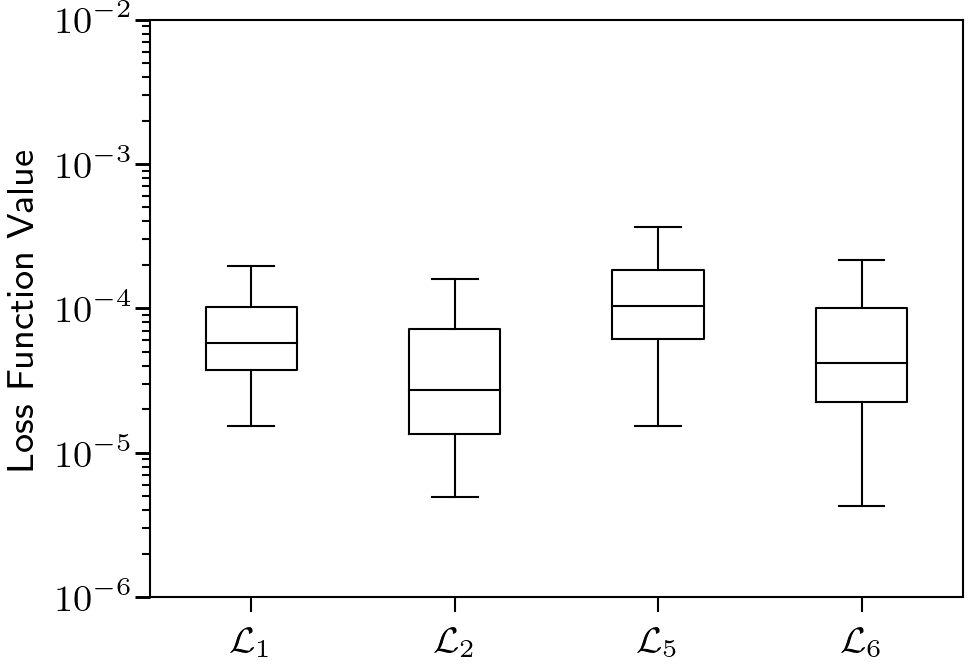

In [15]:
plt.rcdefaults()
plot_params = half_params.copy()
plot_params.update(boxplot_params)
plt.rcParams.update(plot_params)

loss_boxplot(expt, dataset_name='test1')

# Save, if saving figures
if saveallfigs or savesumfigs:
    plt.savefig("{}-boxplot.png".format(expt.name))

plt.show()

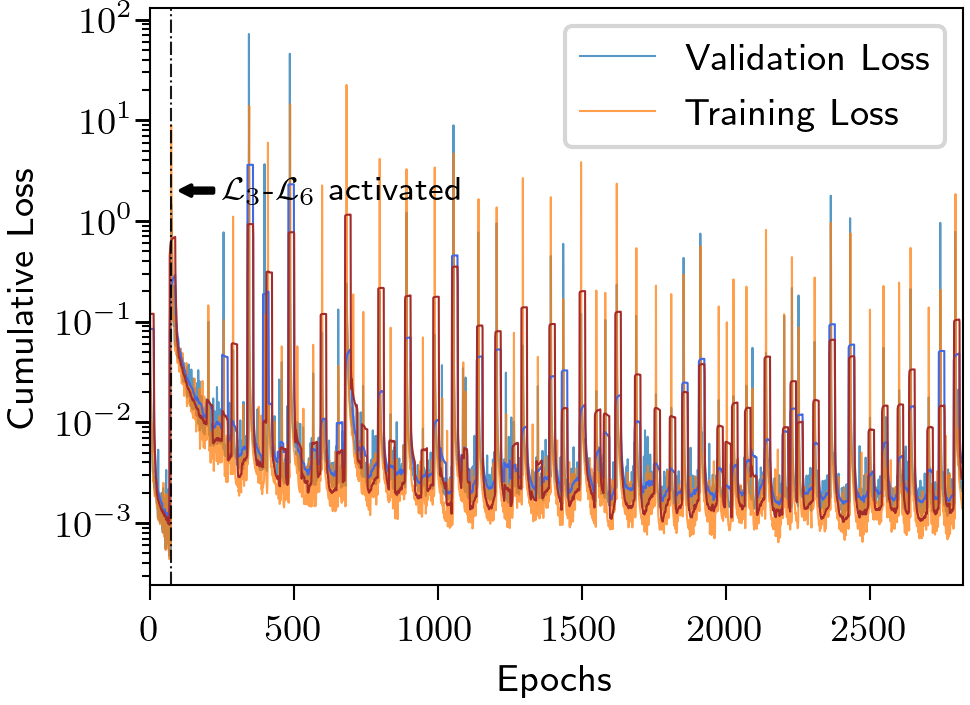

In [14]:
# Set up plotting options
plt.rcdefaults()
plot_params = half_params.copy()
plot_params['lines.linewidth'] = 0.5
plot_params['font.size'] = 8
plt.rcParams.update(plot_params)

###########################
## Val/Train Loss Curves
###########################
training_loss_epochs_plot(expt, roll_window=20)

if saveallfigs:
    plt.savefig("{}-TrainingLoss.png".format(expt.name), transparent=True)

plt.show()

In [8]:
x = 2.674e-5
str_x = "{:.0e}".format(x)
y = float(str_x)
print(y)
print(y-x)

3e-05
3.2599999999999993e-06
